In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import statsmodels.api as sm

**Info about original data:**
- Original data = Headway Data, 8-1-2023 to 9-30-2023.xlsx
- Number of observations: 350,328 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350328 entries, 0 to 350327
Data columns (total 30 columns):
Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350328 non-null  int64         
 1   SERVICE_ABBR               350328 non-null  int64         
 2   ADHERENCE_ID               350328 non-null  int64         
 3   DATE                       350328 non-null  datetime64[ns]
 4   ROUTE_ABBR                 350328 non-null  int64         
 5   BLOCK_ABBR                 350328 non-null  int64         
 6   OPERATOR                   350328 non-null  int64         
 7   TRIP_ID                    350328 non-null  int64         
 8   OVERLOAD_ID                350328 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350328 non-null  object        
 10  TIME_POINT_ABBR            350328 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350317 non-null  float64       
 12  TRIP_EDGE                  350328 non-null  int64         
 13  LATITUDE                   350328 non-null  float64       
 14  LONGITUDE                  350328 non-null  float64       
 15  SCHEDULED_TIME             350328 non-null  object        
 16  ACTUAL_ARRIVAL_TIME        338869 non-null  object        
 17  ACTUAL_DEPARTURE_TIME      338860 non-null  object        
 18  ADHERENCE                  338860 non-null  float64       
 19  SCHEDULED_HDWY             274737 non-null  float64       
 20  ACTUAL_HDWY                266061 non-null  float64       
 21  HDWY_DEV                   265892 non-null  float64       
 22  ADJUSTED_EARLY_COUNT       350328 non-null  int64         
 23  ADJUSTED_LATE_COUNT        350328 non-null  int64         
 24  ADJUSTED_ONTIME_COUNT      350328 non-null  int64         
 25  STOP_CANCELLED             350328 non-null  int64         
 26  PREV_SCHED_STOP_CANCELLED  279999 non-null  float64       
 27  IS_RELIEF                  350328 non-null  int64         
 28  BLOCK_STOP_ORDER           350328 non-null  int64         
 29  DWELL_IN_MINS              338857 non-null  float64 
 
- We removed null values because there were only 265,892 observations with existing HDWY_DEV columns. New dataframe -> headway_data, 265884 entries (75.89%)
- Also removed outliers from the HDWY_DEV and ADHERENCE columns. New dataframe -> processed_data, 254299 entries (72% of original data OR 95.64% of data after removing null values). 
- Data cleanup was based on keeping the 99.9th percentile of the data's HDWY_DEV and ADHERENCE z-scores. Dataset was grouped into each UNIQUE_TRIP_ID (this is the unique ID for each trip on a specific day; trip numbers were reused after a couple days). Z-scores were calculated for the HDWY_DEV and ADHERENCE columns and if the values fell outside of the 99.9th percentile, which meant values below the 0.1st percentile and above the 99.9th percentile. 

In [2]:
processed_data = pd.read_csv("../data/processed_data.csv")
processed_data.head(2)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID,PREVIOUS_ADHERENCE,NEXT_ADHERENCE
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,80,0.0,-0.032222,-0.139835,0.510757,120230801_345106,NaN,-1.916666
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,70,0.0,0.056190,0.202259,0.244098,120230801_345106,-0.183333,-1.716666


**Question:** What is the relationship between adherence and headway deviation? 

In [43]:
lm = smf.ols('HDWY_DEV ~ ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                 6.073e+04
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:27:20   Log-Likelihood:            -7.3185e+05
No. Observations:              254299   AIC:                         1.464e+06
Df Residuals:                  254297   BIC:                         1.464e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6159      0.011   -145.315      0.000      -1.638      -1.594
ADHERENCE     -0.5678      0.002   -246.427      0.000      -0.572      -0.563
==============================================================================
Omnibus:                    40022.024   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           317317.174
Skew:                          -0.533   Prob(JB):                         0.00
Kurtosis:                       8.367   Cond. No.                         6.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Results:**
- The F-statistic is a test statistic used to assess the overall significance of the model. The F-statistic is 6.073e+04, and the p-value is 0.00, indicating that the model is statistically significant.
- The **intercept** is the predicted value of 'HDWY_DEV' when 'ADHERENCE' is zero.
- Both coefficients have very low p-values (close to 0), indicating that they are **statistically significant**.
- R-squared of 0.193, indicate that approximately 19.3% of the variance in HDWY_DEV is explained by the model.

mean(ADHERENCE) = -1.6159 - 0.5678(HDWY_DEV)

- For every one-minute change in 'ADHERENCE', 'HDWY_DEV' is expected to decrease by approximately -0.5678 minutes (or about 34 seconds). The negative sign means that as 'ADHERENCE' increases (the bus leaves before the scheduled time), 'HDWY_DEV' is expected to decrease (become more negative).

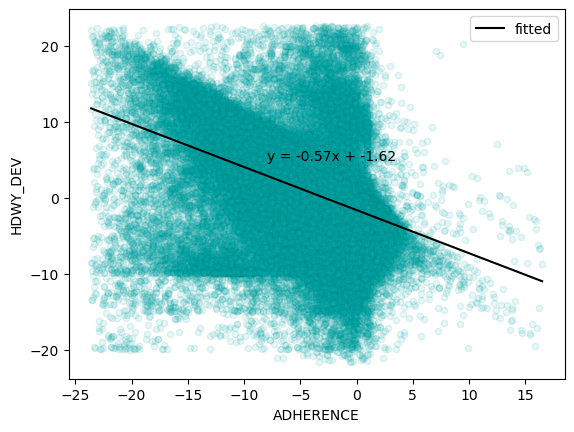

In [44]:
m = lm.params['ADHERENCE']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'ADHERENCE', y = 'HDWY_DEV', kind = 'scatter', s = 20, color = 'c', edgecolor = 'teal', linewidth=1, alpha=0.1); #cyan
ax.text(
    -8, 5, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'ADHERENCE': np.linspace(
        start = processed_data['ADHERENCE'].min(),
        stop = processed_data['ADHERENCE'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'ADHERENCE', y = 'fitted', ax = ax, color = 'black', label = 'fitted');

plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/adherence_vs_hdwydev2.png');

**Question:** What is the relationship between previous adherence on the next adherence? 

In [49]:
# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data['PREVIOUS_ADHERENCE'].corr(processed_data['NEXT_ADHERENCE'])
print("Correlation between first stop adherence and next stop adherence:", correlation)

Correlation between first stop adherence and next stop adherence: 0.700549331688534


In [45]:
lm = smf.ols('NEXT_ADHERENCE ~ PREVIOUS_ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         NEXT_ADHERENCE   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                 1.256e+05
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:33:41   Log-Likelihood:            -3.1772e+05
No. Observations:              130280   AIC:                         6.355e+05
Df Residuals:                  130278   BIC:                         6.355e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.9873      0.010    -97.255      0.000      -1.007      -0.967
PREVIOUS_ADHERENCE     0.7467      0.002    354.337      0.000       0.743       0.751
==============================================================================
Omnibus:                    34921.944   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           261722.936
Skew:                          -1.089   Prob(JB):                         0.00
Kurtosis:                       9.593   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

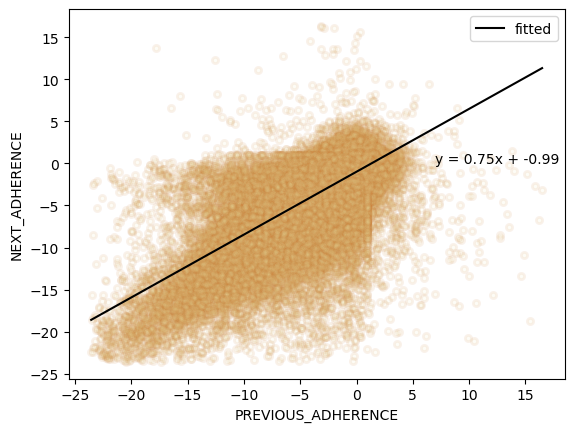

In [46]:
m = lm.params['PREVIOUS_ADHERENCE']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'PREVIOUS_ADHERENCE', y = 'NEXT_ADHERENCE', kind = 'scatter', s = 20, color = 'palegoldenrod', edgecolor = 'peru', linewidth=2, alpha = 0.1)

ax.text(
    7, 0, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'PREVIOUS_ADHERENCE': np.linspace(
        start = processed_data['PREVIOUS_ADHERENCE'].min(),
        stop = processed_data['PREVIOUS_ADHERENCE'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'PREVIOUS_ADHERENCE', y = 'fitted', ax = ax, color = 'black', label = 'fitted');

plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/prevadherence_vs_nextadherence2.png');

**Question:** What is the relationship between previous headway deviation on next headway deviation? 

In [6]:
# Calculate lagged adherence values for each stop
processed_data['PREVIOUS_HDWY_DEV'] = processed_data.groupby('UNIQUE_TRIP_ID')['HDWY_DEV'].shift(1)
processed_data['NEXT_HDWY_DEV'] = processed_data.groupby('UNIQUE_TRIP_ID')['HDWY_DEV'].shift(-1)

# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data['PREVIOUS_HDWY_DEV'].corr(processed_data['NEXT_HDWY_DEV'])
print("Correlation between first stop headway deviation and next stop headway deviation:", correlation)

Correlation between first stop headway deviation and next stop headway deviation: 0.545366112026422


In [38]:
lm = smf.ols('NEXT_HDWY_DEV ~ PREVIOUS_HDWY_DEV', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          NEXT_HDWY_DEV   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                 5.515e+04
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:22:23   Log-Likelihood:            -3.6983e+05
No. Observations:              130280   AIC:                         7.397e+05
Df Residuals:                  130278   BIC:                         7.397e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0514      0.011      4.481      0.000       0.029       0.074
PREVIOUS_HDWY_DEV     0.5616      0.002    234.843      0.000       0.557       0.566
==============================================================================
Omnibus:                    18923.336   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           224683.012
Skew:                           0.296   Prob(JB):                         0.00
Kurtosis:                       9.406   Cond. No.                         4.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

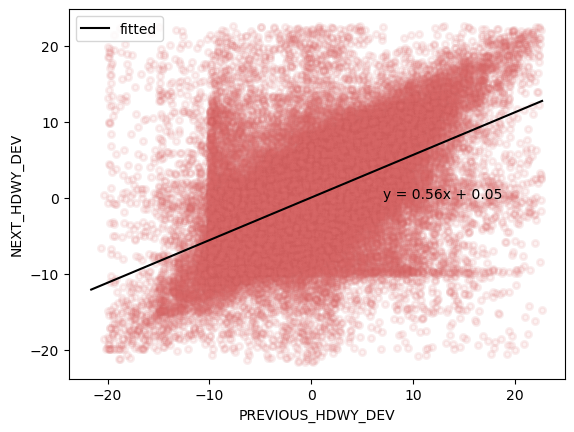

In [41]:
m = lm.params['PREVIOUS_HDWY_DEV']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'PREVIOUS_HDWY_DEV', y = 'NEXT_HDWY_DEV', kind = 'scatter', s = 20, color = 'lightcoral', edgecolor = 'indianred', linewidth=2, alpha = 0.1)

ax.text(
    7, 0, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'PREVIOUS_HDWY_DEV': np.linspace(
        start = processed_data['PREVIOUS_HDWY_DEV'].min(),
        stop = processed_data['PREVIOUS_HDWY_DEV'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'PREVIOUS_HDWY_DEV', y = 'fitted', ax = ax, color = 'black', label = 'fitted');

plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/prevhdwydev_vs_nexthdwydev2.png');

**Question:** How does adherence at previous stop affect headway deviation at next stop?

In [52]:
correlation = processed_data['ADHERENCE'].corr(processed_data['NEXT_HDWY_DEV'])
print("Correlation between first stop adherence and next stop headway deviation:", correlation)

Correlation between first stop adherence and next stop headway deviation: -0.36746911987986525


In [48]:
lm = smf.ols('NEXT_HDWY_DEV ~ ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          NEXT_HDWY_DEV   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                 2.997e+04
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:45:48   Log-Likelihood:            -5.6121e+05
No. Observations:              191985   AIC:                         1.122e+06
Df Residuals:                  191983   BIC:                         1.122e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3692      0.013   -101.808      0.000      -1.396      -1.343
ADHERENCE     -0.4915      0.003   -173.122      0.000      -0.497      -0.486
==============================================================================
Omnibus:                    19910.878   Durbin-Watson:                   1.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           135969.546
Skew:                          -0.257   Prob(JB):                         0.00
Kurtosis:                       7.091   Cond. No.                         6.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

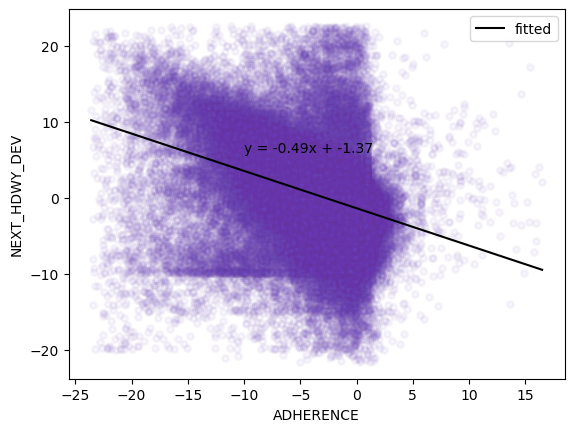

In [57]:
m = lm.params['ADHERENCE']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'ADHERENCE', y = 'NEXT_HDWY_DEV', kind = 'scatter', s = 20, color = 'mediumslateblue', edgecolor = 'rebeccapurple', linewidth=2, alpha = 0.05)

ax.text(
    -10, 6, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'ADHERENCE': np.linspace(
        start = processed_data['ADHERENCE'].min(),
        stop = processed_data['ADHERENCE'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'ADHERENCE', y = 'fitted', ax = ax, color = 'black', label = 'fitted');

plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/adherence_vs_nexthdwydev.png');

**Result Interpretation:**
- This model shows that there's a statistically significant relationship between ADHERENCE and NEXY_HDWY_DEV because it has low p-values. 
- (Intercept) When ADHERENCE is zero (When you leave on time), the estimated headway deviation at the next stop is -1.36 (or the bus arrives about a minute earlier..ie there's some bunching). 
- This model shows that when there's a one-minute increase in ADHERENCE, the headway deviation at the next stop is estimated to decrease by 0.4915 (or about half a minute). 
- Generally, when ADHERENCE increases (departure after scheduled time), NEXY_HDWY_DEV tends to decrease (indicating a shorter headway than scheduled). 